In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision

import matplotlib.pyplot as plt

In [17]:
transform = transforms.ToTensor()

In [206]:
batch_size = 128

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [207]:
train_it = iter(train_loader)

In [208]:
samples, labels = train_it.next()
samples.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

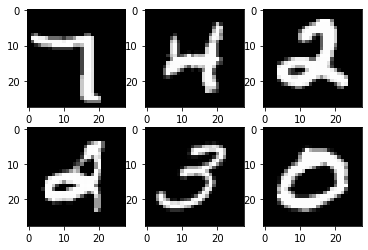

In [209]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

### Net

#### Encoder

In [210]:
class CNN_Encoder(nn.Module):
    def __init__(self, in_channels, hidden_dim):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1) #1x28x28 -> MP 2x2
        self.mp1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) #32x14x14
        self.mp2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) #64x7x7
        self.lin = nn.Linear(64*7*7, hidden_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.mp1(x) #bs,c,14,14
        x = F.relu(self.conv2(x))
        x = self.mp2(x) #bs,c,7,7
        x = F.relu(self.conv3(x))
        
        x = x.reshape(-1, 64*7*7)
        out = F.leaky_relu(self.lin(x))
        
        return out

In [211]:
encoder = CNN_Encoder(1,49*64)
encoder(samples).shape

torch.Size([128, 3136])

#### Decoder

In [212]:
inp = torch.randn((1,49*64))

In [213]:
class CNN_Decoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.convt1 = nn.ConvTranspose2d(64,32,kernel_size=3,padding=1) #7x7
        self.convt2 = nn.ConvTranspose2d(32,16,kernel_size=3,padding=1) #7x7
        self.convt3 = nn.ConvTranspose2d(16,1,kernel_size=3,padding=1) #7x7
        self.lin1 = nn.Linear(7*7, 1*28*28)
        
    def forward(self, x):
        x = F.relu(self.convt1(x))
        x = F.relu(self.convt2(x))
        x = F.relu(self.convt3(x))
        
        x = x.reshape(-1, 1*7*7)
        out = torch.sigmoid(self.lin1(x))
        return out.reshape(-1,1,28,28)

In [214]:
class AutoEncoder(nn.Module):
    def __init__(self, e_channels, e_dim, d_channels):
        super().__init__()
        self.encoder = CNN_Encoder(e_channels, e_dim).to(device)
        self.decoder = CNN_Decoder(d_channels).to(device)
        
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        
    def forward(self, x):
        x = self.encode(x)
        x = x.reshape(-1,64,7,7)
        x = self.decode(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)
        
    def decode(self, x):
        return self.decoder(x)
    
    def train_step(self, x):
        decoded = self.forward(x)
        
        self.optimizer.zero_grad()
        loss = self.criterion(decoded, x)
        loss.backward()
        self.optimizer.step()
        
        return loss.cpu().item()

In [215]:
ae_model = AutoEncoder(1,49*64,64)

#### training loop

In [225]:
test_iter = iter(test_loader)
samples, _ = test_iter.next()
test_samples = samples[:6]

In [226]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [227]:
# training loop
num_epochs = 30
n_steps = len(train_loader)

In [228]:
ae_model = AutoEncoder(1,49*64,64).to(device)

In [229]:
samples = []

for epoch in range(num_epochs):
    for i,(images, labels) in enumerate(train_loader):
        images = images.reshape(-1,1,28,28).to(device)
        
        #forward
        loss = ae_model.train_step(images)

        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_steps}, loss = {loss:.4f}')
    
    with torch.no_grad():
        outputs = ae_model(test_samples.to(device)).cpu()
        samples.append(outputs)

epoch 1 / 30, step 100/469, loss = 0.0597
epoch 1 / 30, step 200/469, loss = 0.0495
epoch 1 / 30, step 300/469, loss = 0.0357
epoch 1 / 30, step 400/469, loss = 0.0308
epoch 2 / 30, step 100/469, loss = 0.0277
epoch 2 / 30, step 200/469, loss = 0.0279
epoch 2 / 30, step 300/469, loss = 0.0243
epoch 2 / 30, step 400/469, loss = 0.0223
epoch 3 / 30, step 100/469, loss = 0.0210
epoch 3 / 30, step 200/469, loss = 0.0195
epoch 3 / 30, step 300/469, loss = 0.0193
epoch 3 / 30, step 400/469, loss = 0.0183
epoch 4 / 30, step 100/469, loss = 0.0170
epoch 4 / 30, step 200/469, loss = 0.0156
epoch 4 / 30, step 300/469, loss = 0.0158
epoch 4 / 30, step 400/469, loss = 0.0144
epoch 5 / 30, step 100/469, loss = 0.0145
epoch 5 / 30, step 200/469, loss = 0.0140
epoch 5 / 30, step 300/469, loss = 0.0140
epoch 5 / 30, step 400/469, loss = 0.0142
epoch 6 / 30, step 100/469, loss = 0.0145
epoch 6 / 30, step 200/469, loss = 0.0136
epoch 6 / 30, step 300/469, loss = 0.0125
epoch 6 / 30, step 400/469, loss =

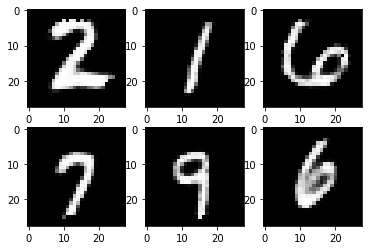

In [235]:
s = samples[-1]

for i in range(len(samples[0])):
    plt.subplot(2, 3, i+1)
    plt.imshow(s[i][0], cmap='gray')
plt.show()